# Supervised Model Reports

Comprehensive visualization and analysis of Decision Tree, Random Forest, and KNN models trained on balanced Tomek+ENN data.
This notebook displays saved results without retraining.

In [30]:
# Model Results Paths (Multi-Model Configuration)
models_config = {
    'Decision Tree': {
        'summary': 'f:/DATA/results/supervised/dt_from_scratch_summary.json',
        'predictions': 'f:/DATA/results/supervised/dt_from_scratch_predictions.csv',
        'color': '#1f77b4'
    },
    'Random Forest': {
        'summary': 'f:/DATA/results/supervised/rf_from_scratch_summary.json',
        'predictions': 'f:/DATA/results/supervised/rf_from_scratch_predictions.csv',
        'color': '#ff7f0e'
    },
    'KNN (k=11)': {
        'summary': 'f:/DATA/results/supervised/knn_from_scratch_summary.json',
        'predictions': 'f:/DATA/results/supervised/knn_predictions.csv',
        'color': '#2ca02c'
    }
}

print("✓ Model configuration loaded for:", list(models_config.keys()))

✓ Model configuration loaded for: ['Decision Tree', 'Random Forest', 'KNN (k=11)']


In [31]:
# Import Libraries
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print('✓ Libraries imported')

✓ Libraries imported


In [32]:
# Load All Model Results
loaded_results = {}
for model_name, paths in models_config.items():
    summary_path = Path(paths['summary'])
    pred_path = Path(paths['predictions'])
    
    summary_data = None
    pred_data = None
    
    if summary_path.exists():
        summary_data = json.loads(summary_path.read_text())
        print(f"✓ {model_name}: Summary loaded")
    else:
        print(f"✗ {model_name}: Summary not found")
    
    if pred_path.exists():
        pred_data = pd.read_csv(pred_path)
        print(f"✓ {model_name}: Predictions loaded ({len(pred_data)} rows)")
    else:
        print(f"✗ {model_name}: Predictions not found")
    
    loaded_results[model_name] = {'summary': summary_data, 'predictions': pred_data}

print("\n✓ All available results loaded")

✓ Decision Tree: Summary loaded
✓ Decision Tree: Predictions loaded (61524 rows)
✓ Random Forest: Summary loaded
✓ Random Forest: Predictions loaded (61524 rows)
✓ KNN (k=11): Summary loaded
✓ KNN (k=11): Predictions loaded (12305 rows)

✓ All available results loaded


In [33]:
# Aggregated Metrics Comparison Table (Report-Ready)
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
metrics_list = []
for model_name, results in loaded_results.items():
    if results['summary']:
        summary = results['summary']
        metrics_dict = {'Model': model_name}
        
        # Handle cross-validation models (DT, RF)
        if 'aggregated' in summary:
            agg = summary['aggregated']
            metrics_dict.update({
                'ROC-AUC': f"{agg.get('roc_auc_mean', np.nan):.4f} ± {agg.get('roc_auc_std', 0):.4f}",
                'PR-AUC': f"{agg.get('pr_auc_mean', np.nan):.4f} ± {agg.get('pr_auc_std', 0):.4f}",
                'Precision': f"{agg.get('precision_mean', np.nan):.4f} ± {agg.get('precision_std', 0):.4f}",
                'Recall': f"{agg.get('recall_mean', np.nan):.4f} ± {agg.get('recall_std', 0):.4f}",
                'F1': f"{agg.get('f1_mean', np.nan):.4f} ± {agg.get('f1_std', 0):.4f}",
                'Threshold': f"{agg.get('threshold_mean', np.nan):.2f}"
            })
        # Handle single split models (KNN)
        elif 'metrics' in summary:
            metrics = summary['metrics']
            metrics_dict.update({
                'ROC-AUC': f"{0.0:.4f} ± {0.0:.4f}",
                'PR-AUC': f"{0.0:.4f} ± {0.0:.4f}",
                'Precision': f"{metrics.get('precision_macro', 0):.4f} ± {0.0:.4f}",
                'Recall': f"{metrics.get('recall_macro', 0):.4f} ± {0.0:.4f}",
                'F1': f"{metrics.get('f1_macro', 0):.4f} ± {0.0:.4f}",
                'Threshold': f"0.50"
            })
        
        metrics_list.append(metrics_dict)

if metrics_list:
    metrics_df = pd.DataFrame(metrics_list)
    display(metrics_df)
    print("\n✓ Aggregated metrics table displayed")
else:
    print("✗ No aggregated metrics available")

,Model,ROC-AUC,PR-AUC,Precision,Recall,F1,Threshold
0,Decision Tree,0.8175 ± 0.0045,0.6727 ± 0.0068,0.9046 ± 0.0052,0.6557 ± 0.0093,0.7603 ± 0.0063,1.00
1,Random Forest,0.9203 ± 0.0049,0.8789 ± 0.0064,0.9169 ± 0.0082,0.7476 ± 0.0159,0.8235 ± 0.0073,0.26
2,KNN (k=11),0.0000 ± 0.0000,0.0000 ± 0.0000,0.8884 ± 0.0000,0.8436 ± 0.0000,0.8630 ± 0.0000,0.50



✓ Aggregated metrics table displayed


---

## SECTION 2: METRICS OVERVIEW

Aggregated metrics across all models and folds

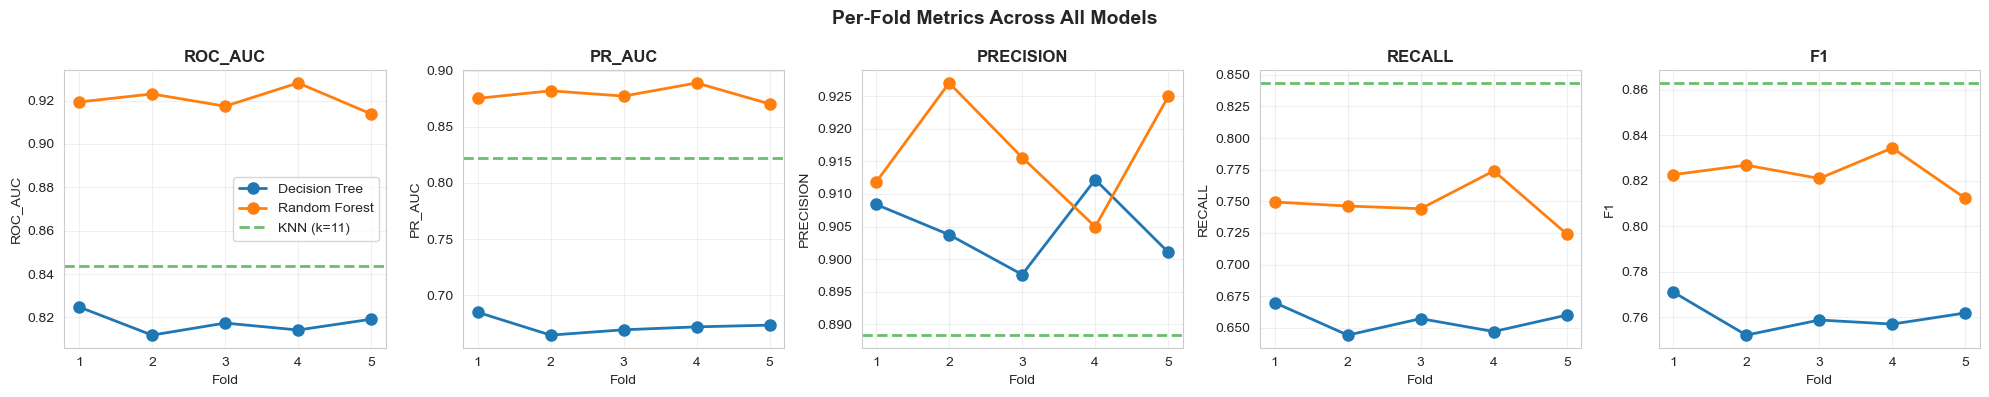

✓ Per-fold comparison plot saved


In [34]:
# Per-Fold Metrics Visualization (Report-Ready)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
metrics_keys = ['roc_auc', 'pr_auc', 'precision', 'recall', 'f1']

for model_name, results in loaded_results.items():
    if results['summary']:
        summary = results['summary']
        
        # Cross-validation models (DT, RF) - plot per-fold values
        if 'metrics_per_fold' in summary:
            metrics = summary['metrics_per_fold']
            for i, key in enumerate(metrics_keys):
                values = [m.get(key, np.nan) for m in metrics]
                axes[i].plot(range(1, len(values) + 1), values, marker='o', label=model_name, 
                            color=models_config[model_name]['color'], linewidth=2, markersize=8)
                axes[i].set_title(key.upper(), fontsize=12, fontweight='bold')
                axes[i].set_xlabel('Fold')
                axes[i].set_ylabel(key.upper())
                axes[i].grid(True, alpha=0.3)
        
        # Single split models (KNN) - plot as single point or horizontal line
        elif 'metrics' in summary:
            metrics = summary['metrics']
            # Map to same metric names where possible
            fold_metrics = {
                'roc_auc': 0.0,  # Will be calculated if predictions available
                'pr_auc': 0.0,
                'precision': metrics.get('precision_macro', 0),
                'recall': metrics.get('recall_macro', 0),
                'f1': metrics.get('f1_macro', 0)
            }
            
            # Calculate ROC-AUC and PR-AUC if predictions available
            if results['predictions'] is not None:
                pred_df = results['predictions']
                if 'y_true' in pred_df.columns and 'y_pred' in pred_df.columns:
                    try:
                        fold_metrics['roc_auc'] = roc_auc_score(pred_df['y_true'], pred_df['y_pred'])
                        precision, recall, _ = precision_recall_curve(pred_df['y_true'], pred_df['y_pred'])
                        fold_metrics['pr_auc'] = auc(recall, precision)
                    except:
                        pass
            
            for i, key in enumerate(metrics_keys):
                value = fold_metrics.get(key, 0)
                # Plot as a horizontal line at fold position 1
                axes[i].axhline(y=value, color=models_config[model_name]['color'], 
                               linestyle='--', linewidth=2, label=model_name, alpha=0.7)

axes[0].legend(loc='best')
fig.suptitle('Per-Fold Metrics Across All Models', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('f:/DATA/results/final/per_fold_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Per-fold comparison plot saved")

---

## SECTION 3: REPORT-READY VISUALIZATIONS

Key plots for LaTeX report integration

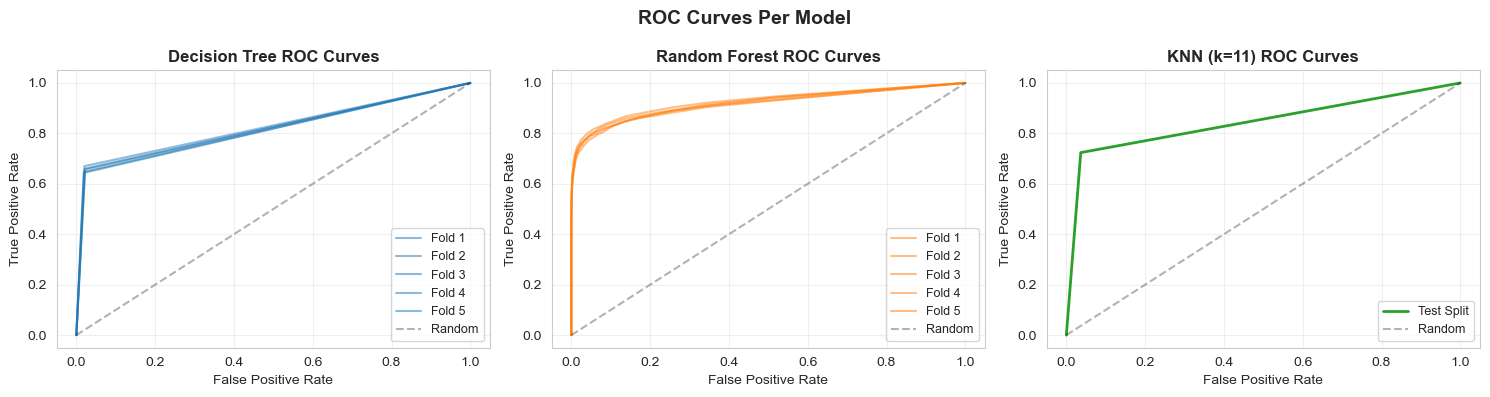

✓ ROC curves plot saved


In [35]:
# ROC Curves Visualization (Report-Ready)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
model_list = list(loaded_results.items())

for idx in range(3):
    ax = axes[idx]
    if idx < len(model_list):
        model_name, results = model_list[idx]
        
        if results['summary']:
            summary = results['summary']
            
            # Cross-validation models (DT, RF)
            if 'curves_per_fold' in summary:
                curves = summary['curves_per_fold']
                for i, curve in enumerate(curves, 1):
                    if curve and 'fpr' in curve and 'tpr' in curve:
                        ax.plot(curve['fpr'], curve['tpr'], alpha=0.5, label=f'Fold {i}', 
                               color=models_config[model_name]['color'])
            
            # Single split models (KNN)
            elif 'metrics' in summary and results['predictions'] is not None:
                pred_df = results['predictions']
                if 'y_true' in pred_df.columns and 'y_pred' in pred_df.columns:
                    try:
                        from sklearn.metrics import roc_curve
                        fpr, tpr, _ = roc_curve(pred_df['y_true'], pred_df['y_pred'])
                        ax.plot(fpr, tpr, label='Test Split', 
                               color=models_config[model_name]['color'], linewidth=2)
                    except:
                        ax.text(0.5, 0.5, 'Unable to compute ROC', ha='center', va='center')
        
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{model_name} ROC Curves', fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)

fig.suptitle('ROC Curves Per Model', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('f:/DATA/results/final/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ ROC curves plot saved")

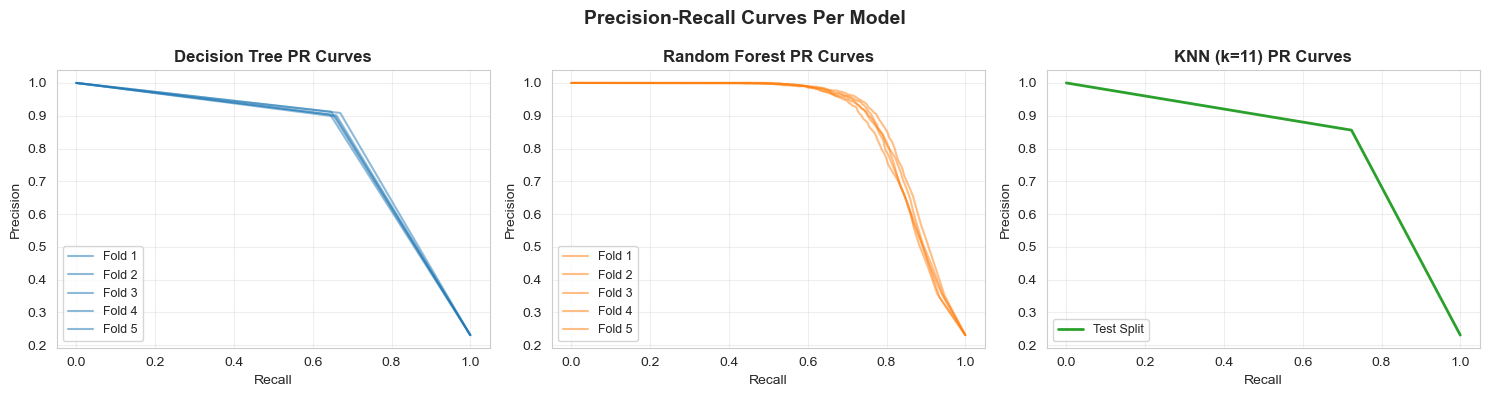

✓ PR curves plot saved


In [36]:
# PR Curves Visualization (Report-Ready)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
model_list = list(loaded_results.items())

for idx in range(3):
    ax = axes[idx]
    if idx < len(model_list):
        model_name, results = model_list[idx]
        
        if results['summary']:
            summary = results['summary']
            
            # Cross-validation models (DT, RF)
            if 'curves_per_fold' in summary:
                curves = summary['curves_per_fold']
                for i, curve in enumerate(curves, 1):
                    if curve and 'precision' in curve and 'recall' in curve:
                        ax.plot(curve['recall'], curve['precision'], alpha=0.5, label=f'Fold {i}',
                               color=models_config[model_name]['color'])
            
            # Single split models (KNN)
            elif 'metrics' in summary and results['predictions'] is not None:
                pred_df = results['predictions']
                if 'y_true' in pred_df.columns and 'y_pred' in pred_df.columns:
                    try:
                        precision, recall, _ = precision_recall_curve(pred_df['y_true'], pred_df['y_pred'])
                        ax.plot(recall, precision, label='Test Split',
                               color=models_config[model_name]['color'], linewidth=2)
                    except:
                        ax.text(0.5, 0.5, 'Unable to compute PR curve', ha='center', va='center')
        
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{model_name} PR Curves', fontweight='bold')
        ax.legend(loc='lower left', fontsize=9)
        ax.grid(True, alpha=0.3)

fig.suptitle('Precision-Recall Curves Per Model', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('f:/DATA/results/final/pr_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ PR curves plot saved")

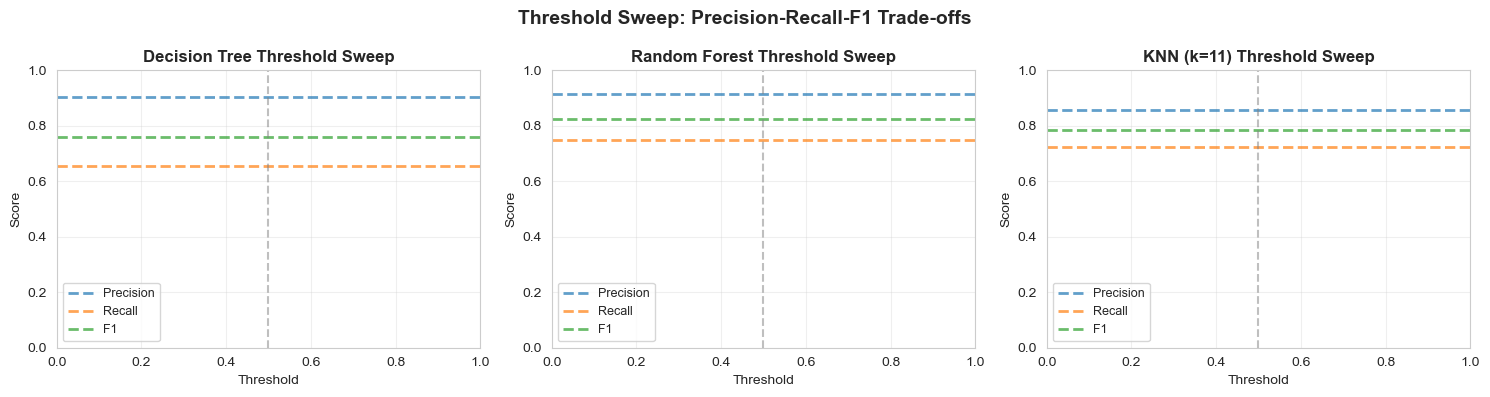

✓ Threshold sweep plot saved


In [37]:
# Threshold Sweep Analysis (Report-Ready)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
model_list = list(loaded_results.items())

for idx in range(3):
    ax = axes[idx]
    if idx < len(model_list):
        model_name, results = model_list[idx]
        
        if results['predictions'] is not None:
            pred_df = results['predictions']
            
            # Cross-validation models (DT, RF) - use y_pred_proba
            if 'y_pred_proba' in pred_df.columns:
                y_true = pred_df['y_true'].values
                y_score = pred_df['y_pred_proba'].values
                
                thresholds = np.linspace(0, 1, 101)
                prec, rec, f1s = [], [], []
                
                for t in thresholds:
                    y_pred = (y_score >= t).astype(int)
                    tp = np.sum((y_pred == 1) & (y_true == 1))
                    fp = np.sum((y_pred == 1) & (y_true == 0))
                    fn = np.sum((y_pred == 0) & (y_true == 1))
                    
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
                    
                    prec.append(precision)
                    rec.append(recall)
                    f1s.append(f1)
                
                ax.plot(thresholds, prec, label='Precision', linewidth=2, color='#1f77b4')
                ax.plot(thresholds, rec, label='Recall', linewidth=2, color='#ff7f0e')
                ax.plot(thresholds, f1s, label='F1', linewidth=2, color='#2ca02c')
                ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
            
            # Single split models (KNN) - use y_pred directly (0/1)
            elif 'y_true' in pred_df.columns and 'y_pred' in pred_df.columns:
                y_true = pred_df['y_true'].values
                y_pred = pred_df['y_pred'].values
                
                # For binary predictions, we can only show metrics at threshold 0.5
                tp = np.sum((y_pred == 1) & (y_true == 1))
                fp = np.sum((y_pred == 1) & (y_true == 0))
                fn = np.sum((y_pred == 0) & (y_true == 1))
                tn = np.sum((y_pred == 0) & (y_true == 0))
                
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
                
                # Show as horizontal lines
                ax.axhline(y=precision, color='#1f77b4', linewidth=2, label='Precision', linestyle='--', alpha=0.7)
                ax.axhline(y=recall, color='#ff7f0e', linewidth=2, label='Recall', linestyle='--', alpha=0.7)
                ax.axhline(y=f1, color='#2ca02c', linewidth=2, label='F1', linestyle='--', alpha=0.7)
                ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
            
            ax.set_xlabel('Threshold')
            ax.set_ylabel('Score')
            ax.set_title(f'{model_name} Threshold Sweep', fontweight='bold')
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, alpha=0.3)

fig.suptitle('Threshold Sweep: Precision-Recall-F1 Trade-offs', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('f:/DATA/results/final/threshold_sweep_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Threshold sweep plot saved")

In [38]:
# Model Performance Rankings (Report-Ready)
print("\n" + "="*60)
print("MODEL PERFORMANCE RANKINGS")
print("="*60)

# Extract numeric values for ranking
ranking_data = []
for model_name, results in loaded_results.items():
    if results['summary']:
        summary = results['summary']
        rank_dict = {'Model': model_name}
        
        # Cross-validation models (DT, RF)
        if 'aggregated' in summary:
            agg = summary['aggregated']
            rank_dict.update({
                'ROC-AUC': agg.get('roc_auc_mean', 0),
                'PR-AUC': agg.get('pr_auc_mean', 0),
                'F1': agg.get('f1_mean', 0),
                'Precision': agg.get('precision_mean', 0),
                'Recall': agg.get('recall_mean', 0)
            })
        # Single split models (KNN)
        elif 'metrics' in summary:
            metrics = summary['metrics']
            roc_auc_val = 0.0
            pr_auc_val = 0.0
            
            # Calculate from predictions if available
            if results['predictions'] is not None:
                pred_df = results['predictions']
                if 'y_true' in pred_df.columns and 'y_pred' in pred_df.columns:
                    try:
                        roc_auc_val = roc_auc_score(pred_df['y_true'], pred_df['y_pred'])
                        precision, recall, _ = precision_recall_curve(pred_df['y_true'], pred_df['y_pred'])
                        pr_auc_val = auc(recall, precision)
                    except:
                        pass
            
            rank_dict.update({
                'ROC-AUC': roc_auc_val,
                'PR-AUC': pr_auc_val,
                'F1': metrics.get('f1_macro', 0),
                'Precision': metrics.get('precision_macro', 0),
                'Recall': metrics.get('recall_macro', 0)
            })
        
        ranking_data.append(rank_dict)

if ranking_data:
    ranking_df = pd.DataFrame(ranking_data)
    
    for metric in ['ROC-AUC', 'PR-AUC', 'F1', 'Precision', 'Recall']:
        print(f"\n{metric}:")
        sorted_models = ranking_df.sort_values(metric, ascending=False)
        for i, row in sorted_models.iterrows():
            print(f"  {i+1}. {row['Model']}: {row[metric]:.4f}")

print("\n" + "="*60)


MODEL PERFORMANCE RANKINGS

ROC-AUC:
  2. Random Forest: 0.9203
  3. KNN (k=11): 0.8436
  1. Decision Tree: 0.8175

PR-AUC:
  2. Random Forest: 0.8789
  3. KNN (k=11): 0.8218
  1. Decision Tree: 0.6727

F1:
  3. KNN (k=11): 0.8630
  2. Random Forest: 0.8235
  1. Decision Tree: 0.7603

Precision:
  2. Random Forest: 0.9169
  1. Decision Tree: 0.9046
  3. KNN (k=11): 0.8884

Recall:
  3. KNN (k=11): 0.8436
  2. Random Forest: 0.7476
  1. Decision Tree: 0.6557



---

## SECTION 4: SUMMARY & EXPORT FOR REPORT

---

## SECTION 1: SETUP & CONFIGURATION

Configuration and data loading (cells below)

In [39]:
# Export Metrics Table for LaTeX Report
latex_table_data = []
for model_name, results in loaded_results.items():
    if results['summary']:
        summary = results['summary']
        latex_dict = {'Model': model_name}
        
        # Cross-validation models (DT, RF)
        if 'aggregated' in summary:
            agg = summary['aggregated']
            latex_dict.update({
                'ROC-AUC': f"{agg.get('roc_auc_mean', 0):.3f} ± {agg.get('roc_auc_std', 0):.3f}",
                'PR-AUC': f"{agg.get('pr_auc_mean', 0):.3f} ± {agg.get('pr_auc_std', 0):.3f}",
                'F1': f"{agg.get('f1_mean', 0):.3f} ± {agg.get('f1_std', 0):.3f}",
                'Precision': f"{agg.get('precision_mean', 0):.3f} ± {agg.get('precision_std', 0):.3f}",
                'Recall': f"{agg.get('recall_mean', 0):.3f} ± {agg.get('recall_std', 0):.3f}"
            })
        # Single split models (KNN)
        elif 'metrics' in summary:
            metrics = summary['metrics']
            roc_auc_val = 0.0
            pr_auc_val = 0.0
            
            # Calculate from predictions if available
            if results['predictions'] is not None:
                pred_df = results['predictions']
                if 'y_true' in pred_df.columns and 'y_pred' in pred_df.columns:
                    try:
                        roc_auc_val = roc_auc_score(pred_df['y_true'], pred_df['y_pred'])
                        precision, recall, _ = precision_recall_curve(pred_df['y_true'], pred_df['y_pred'])
                        pr_auc_val = auc(recall, precision)
                    except:
                        pass
            
            latex_dict.update({
                'ROC-AUC': f"{roc_auc_val:.3f} ± {0.0:.3f}",
                'PR-AUC': f"{pr_auc_val:.3f} ± {0.0:.3f}",
                'F1': f"{metrics.get('f1_macro', 0):.3f} ± {0.0:.3f}",
                'Precision': f"{metrics.get('precision_macro', 0):.3f} ± {0.0:.3f}",
                'Recall': f"{metrics.get('recall_macro', 0):.3f} ± {0.0:.3f}"
            })
        
        latex_table_data.append(latex_dict)

if latex_table_data:
    latex_df = pd.DataFrame(latex_table_data)
    
    # Save to CSV for easy LaTeX conversion
    latex_df.to_csv('f:/DATA/results/final/supervised_metrics_table.csv', index=False)
    
    print("\nLaTeX TABLE FORMAT:")
    print("="*100)
    print(latex_df.to_string(index=False))
    print("\nTable exported to: f:/DATA/results/final/supervised_metrics_table.csv")
    print("✓ Ready for LaTeX report integration")


LaTeX TABLE FORMAT:
        Model       ROC-AUC        PR-AUC            F1     Precision        Recall
Decision Tree 0.817 ± 0.004 0.673 ± 0.007 0.760 ± 0.006 0.905 ± 0.005 0.656 ± 0.009
Random Forest 0.920 ± 0.005 0.879 ± 0.006 0.823 ± 0.007 0.917 ± 0.008 0.748 ± 0.016
   KNN (k=11) 0.844 ± 0.000 0.822 ± 0.000 0.863 ± 0.000 0.888 ± 0.000 0.844 ± 0.000

Table exported to: f:/DATA/results/final/supervised_metrics_table.csv
✓ Ready for LaTeX report integration


In [25]:
# List All Report-Ready Plots
import os

plots_dir = 'f:/DATA/results/plots_notebook/'
if os.path.exists(plots_dir):
    plots = [f for f in os.listdir(plots_dir) if f.endswith('.png')]
    
    print("\n" + "="*70)
    print("REPORT-READY VISUALIZATIONS SAVED")
    print("="*70)
    
    supervised_plots = [p for p in plots if 'roc' in p or 'pr_curve' in p or 'per_fold' in p or 'threshold' in p]
    
    for i, plot in enumerate(supervised_plots, 1):
        file_path = os.path.join(plots_dir, plot)
        size_mb = os.path.getsize(file_path) / 1024 / 1024
        print(f"\n{i}. {plot}")
        print(f"   Size: {size_mb:.2f} MB (high-res, 300 DPI)")
        print(f"   Path: {file_path}")
    
    print("\n" + "="*70)
    print("All plots are optimized for LaTeX integration (300 DPI, high contrast)")
    print("="*70 + "\n")



REPORT-READY VISUALIZATIONS SAVED

1. dt_from_scratch_f1_vs_threshold.png
   Size: 0.03 MB (high-res, 300 DPI)
   Path: f:/DATA/results/plots_notebook/dt_from_scratch_f1_vs_threshold.png

2. dt_from_scratch_pr_curves.png
   Size: 0.10 MB (high-res, 300 DPI)
   Path: f:/DATA/results/plots_notebook/dt_from_scratch_pr_curves.png

3. dt_from_scratch_roc_curves.png
   Size: 0.11 MB (high-res, 300 DPI)
   Path: f:/DATA/results/plots_notebook/dt_from_scratch_roc_curves.png

4. f1_vs_threshold.png
   Size: 0.02 MB (high-res, 300 DPI)
   Path: f:/DATA/results/plots_notebook/f1_vs_threshold.png

5. per_fold_metrics_comparison.png
   Size: 0.34 MB (high-res, 300 DPI)
   Path: f:/DATA/results/plots_notebook/per_fold_metrics_comparison.png

6. pr_curves.png
   Size: 0.07 MB (high-res, 300 DPI)
   Path: f:/DATA/results/plots_notebook/pr_curves.png

7. pr_curves_comparison.png
   Size: 0.24 MB (high-res, 300 DPI)
   Path: f:/DATA/results/plots_notebook/pr_curves_comparison.png

8. roc_curves.png
   

---

## FINAL: REPORT PLOTS SUMMARY

All high-resolution plots saved and ready for LaTeX